In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [1]:
PROCESSED_DIR = "data/processed"

In [3]:
patients_to_use = pd.read_csv("data/processed/AL_for_ccp_02.tsv", sep="\t", index_col=0).index
vars_to_use = a.rename(columns=amyloid.ddict_unclean).columns

print("* {} patients".format(patients_to_use.shape[0]))
print("* {} variables".format(vars_to_use.shape[0]))

* 2074 patients
* 28 variables


In [4]:
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean).loc[patients_to_use,:]

In [16]:
# Dataframes
X = data_df.loc[:,vars_to_use]
Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t", index_col=0)

### 1. Initialize PCA
---

<Axes: xlabel='PC 2 (10.15%)', ylabel='PC 1 (11.17%)'>

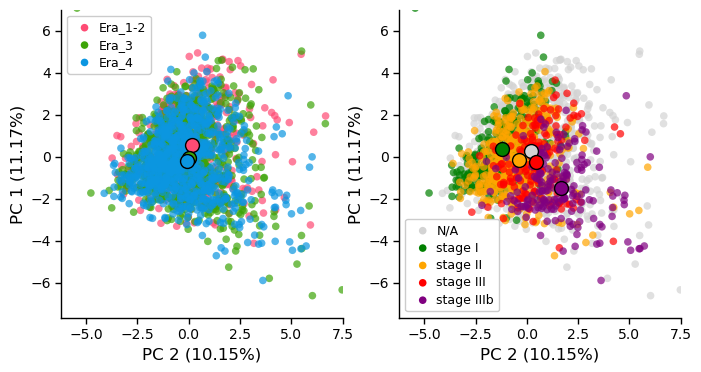

In [29]:
# Using MICE imputed
P_df, pca, pca_vars = utils.get_pcs(Xi_mice)

alpha=0.7
xlim=(None,7.5)
ylim=(None,7)

fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "Era"], 
                 ax=axes[0], 
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

plot.plot_pca_ax(P_df, pca, cohort_s=data_df.loc[P_df.index, "BU (BNP-based) cardiac staging"].fillna("N/A"), 
                 ax=axes[1], 
                 cohort_colors={"stage I":"green","stage II":"orange","stage III":"red","stage IIIb":"purple","N/A":"lightgrey"},
                 xlim=xlim, ylim=ylim,
                 alpha=alpha,
                 add_mean_marker=True
                 )

### 2. Try
---

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

In [ ]:
# Kmeans

range_n_clusters = [2, 3, 4, 5, 6]

/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.6295070337642715
For n_clusters = 3 The average silhouette_score is : 0.6293945601448295


/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.6104318098557422


/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.5928355782221415


/Users/sanand/anaconda3/envs/r4/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.54135788877463


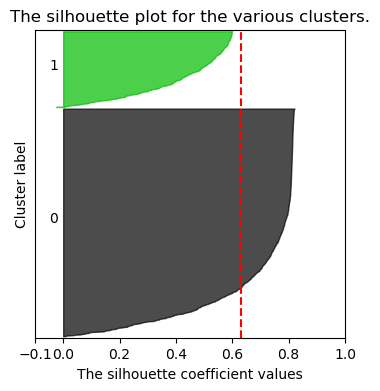

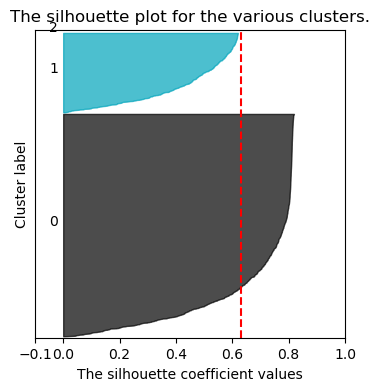

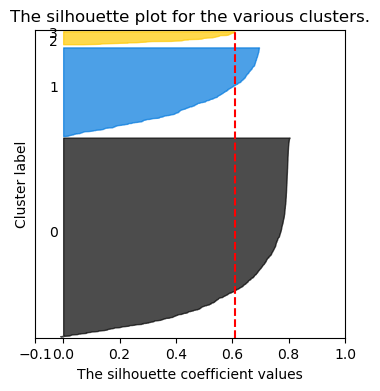

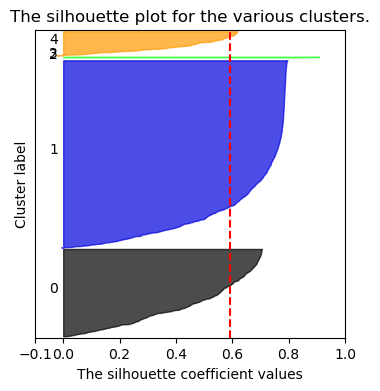

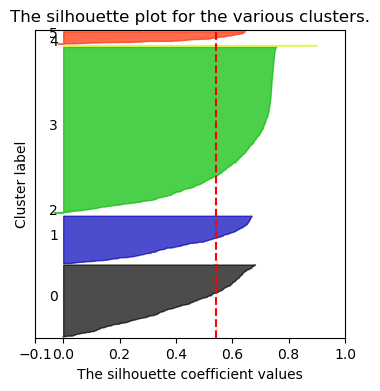

In [36]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig,ax = plt.subplots(figsize=(4,4))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Xi_mice)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xi_mice, cluster_labels)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg,)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xi_mice, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])